In [1]:
import torch
torch.set_default_dtype(torch.float64)
from torch.utils.data import TensorDataset, DataLoader

import math
import gpytorch
from gpytorch.metrics import negative_log_predictive_density, mean_squared_error, mean_standardized_log_loss,mean_absolute_error

import matplotlib
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import numpy as np
from uci_datasets import Dataset
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [63]:

'''
autompg (392, 7)
concreteslump (103, 7)
energy (768, 8)
forest (517, 12)
solar (1066, 10)
stock (536, 11)
yacht (308, 6)
airfoil (1503, 5)
autos (159, 25)
breastcancer (194, 33)
concrete (1030, 8)
housing (506, 13)
machine (209, 7)
pendulum (630, 9)
servo (167, 4)
wine (1599, 11)
'''


# Parameters
datasets = [
    'autompg', 
    'concreteslump', 
    'energy', 
    'forest', 
    'solar', 
    'stock', 
    'yacht',
    'airfoil', 
    'autos', 
    'breastcancer', 
    'concrete', 
    'housing', 
    'machine',
    'pendulum', 
    'servo', 
    'wine',
    'concrete',
]

In [2]:
dataset_name = "housing"
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape

X,y = full_dataset.x, full_dataset.y

if dataset_name=="autos":  
    X = np.delete(X,[8],axis=1)

if dataset_name == "sml":
    X = np.delete(X,[2, 20, 21, 22],axis=1)


X = X / np.std(X, axis=0)[None, :]    # standardize
# X = X - X.min(0)[0]                   # normalize
# X = 2 * (X / X.max(0)[0]) - 1
y = y / np.std(y, axis=0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

len(X_train), len(X_test)

housing dataset, N=506, d=13


(404, 102)

In [3]:
X_train,y_train= torch.from_numpy(X_train),torch.from_numpy(y_train)
X_test,y_test = torch.from_numpy(X_test),torch.from_numpy(y_test)

In [4]:
# GP model with kernel as input
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, kernel=None, mean=None):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean or gpytorch.means.ConstantMean()
        self.covar_module = kernel or gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )
        if isinstance(kernel, gpytorch.kernels.SpectralDeltaKernel) or isinstance(kernel, gpytorch.kernels.SpectralMixtureKernel):
            self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
model = GP(X_train, y_train)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood,model)


loss_vals = []
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    output = model(X_train)
    loss = - mll(output,y_train)
    loss.backward()
    optimizer.step()

    loss_vals.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

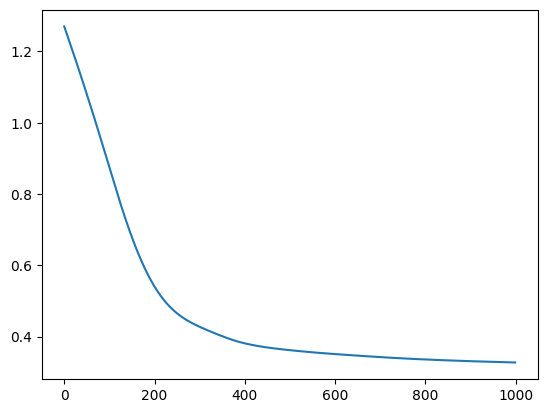

In [17]:
plt.plot(loss_vals)

In [18]:
model.eval()
preds = model.likelihood(model(X_test))
print("MAE: ", mean_absolute_error(preds,y_test).detach().numpy())
print("RMSE: ", torch.sqrt(mean_squared_error(preds,y_test)).detach().numpy())
print("MSLL: ", mean_standardized_log_loss(preds,y_test).detach().numpy())
print("NLPD: ", negative_log_predictive_density(preds,y_test).detach().numpy())

MAE:  0.23363459316769516
RMSE:  0.2996136018951724
MSLL:  0.22039373348719554
NLPD:  0.19846362848379218


In [50]:
scale_params = [p for name,p in model.named_parameters() if 'lengthscale' in name]
scale_params

[Parameter containing:
 tensor([[2.7862, 5.5833, 5.5698, 7.8648, 0.5768, 2.5091, 3.1187, 1.4087, 2.4451,
          0.0332, 5.3436, 5.3319, 0.5863]], requires_grad=True)]

## Kernels

In [261]:
def get_kernels(dim):

    kernels = [
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=dim)),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5,ard_num_dims=dim)),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=dim)),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(ard_num_dims=dim)),
        gpytorch.kernels.LinearKernel(),
        # gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel()),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=2)),
        
        # Spectral kernels: random freqs, learned freqs and learned spectral mixture
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RFFKernel(num_dims=dim,num_samples=150)),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(num_dims=dim,num_deltas=150)),
        gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4),   # this kernel should not be combined with ScaleKernel 
        ]
    
    return kernels

In [262]:
kernel_names = ['RBF',
                'Matern3/2',
                'Matern5/2',
                'RQ',
                'Linear',
                # 'Cos',
                'Poly',
                'RFF-RBF',
                'SpecDelta',
                'SpecMix',
                ]

In [263]:
gamma=0.8
0.1*gamma**np.arange(10)

array([0.1       , 0.08      , 0.064     , 0.0512    , 0.04096   ,
       0.032768  , 0.0262144 , 0.02097152, 0.01677722, 0.01342177])

In [264]:
def run_gp(X_train,y_train,X_test,y_test,kernel):
    model = GP(X_train, y_train,kernel=kernel)

    optimizer = torch.optim.Adam(model.parameters(),lr = 0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood,model)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


    loss_vals = []
    for _ in range(10):             # epochs
        for _ in range(100):        # iterations per epoch
            optimizer.zero_grad()
            output = model(X_train)
            loss = - mll(output,y_train)
            loss.backward()
            optimizer.step()
            loss_vals.append(loss.item())
            
        scheduler.step()    

    model.eval()
    preds = model.likelihood(model(X_test))    

    mae = mean_absolute_error(preds,y_test).detach().numpy().item()
    rmse = torch.sqrt(mean_squared_error(preds,y_test)).detach().numpy().item()
    mlloss = mean_standardized_log_loss(preds,y_test).detach().numpy().item()
    nlpd = negative_log_predictive_density(preds,y_test).detach().numpy().item()

    results = {"mae": [mae],
                'rmse': [rmse],
                'mll': [mlloss],
                'nlpd': [nlpd],
                }

    return results, loss_vals
    

In [265]:
from tqdm.notebook import tqdm  

num_datasets = len(datasets)
num_kernels = 6
num_seeds = 3

test_datasets = datasets[:num_datasets]
all_results = dict()
for name in test_datasets:
    all_results.update({name: dict()})


for dataset_name in test_datasets:
    full_dataset = Dataset(dataset_name)

    progress_bar = tqdm(total=num_kernels * num_seeds, desc=f"Progress for {dataset_name}", unit="iteration")

    X,y = full_dataset.x, full_dataset.y

    if dataset_name=="autos":  
        X = np.delete(X,[8],axis=1)

    if dataset_name == "sml":
        X = np.delete(X,[2, 20, 21, 22],axis=1)

    # standardize
    X = X / np.std(X, axis=0)[None, :]    
    y = y / np.std(y, axis=0)
    for split in range(num_seeds):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=split+50,shuffle=True)

        y_train = y_train.squeeze()
        y_test = y_test.squeeze()

        X_train,y_train,X_test,y_test= torch.from_numpy(X_train),torch.from_numpy(y_train),torch.from_numpy(X_test),torch.from_numpy(y_test)

        kernels = get_kernels(X_train.shape[1])
        kernel_bar = tqdm(total=num_kernels, desc=f"Running kernels for {dataset_name}, split {split}", leave=False)

        for k,kernel in enumerate(kernels[:num_kernels]):
            if kernel_names[k] not in all_results[dataset_name]:
                all_results[dataset_name][kernel_names[k]] = {
                    "rmse": [],
                    "nlpd": [],
                    "mae": [],
                    "mll": []
                }
            try:
                results,_ = run_gp(X_train,y_train,X_test,y_test,kernel)
                # save the results
                all_results[dataset_name][kernel_names[k]]["rmse"].extend(results["rmse"])
                all_results[dataset_name][kernel_names[k]]["nlpd"].extend(results["nlpd"])
                all_results[dataset_name][kernel_names[k]]["mae"].extend(results["mae"])
                all_results[dataset_name][kernel_names[k]]["mll"].extend(results["mll"])
            except Exception as e:
                print(f"Error in dataset {dataset_name}, split {split}, kernel {kernel}: {str(e)}")
            
            progress_bar.update(1) 
            kernel_bar.update(1)
            
        # kernel_bar.close()
        


autompg dataset, N=392, d=7


Progress for autompg:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for autompg, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for autompg, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for autompg, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

concreteslump dataset, N=103, d=7


Progress for concreteslump:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for concreteslump, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for concreteslump, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for concreteslump, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

energy dataset, N=768, d=8


Progress for energy:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for energy, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for energy, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for energy, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

forest dataset, N=517, d=12


Progress for forest:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for forest, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for forest, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for forest, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

solar dataset, N=1066, d=10


Progress for solar:   0%|          | 0/18 [00:00<?, ?iteration/s]

/var/folders/b6/z4591_kn5dz7xy81wtgqr67c0000gp/T/ipykernel_6694/1036783155.py:27: RuntimeWarning: invalid value encountered in divide
  X = X / np.std(X, axis=0)[None, :]


Running kernels for solar, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset solar, split 0, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 0, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 0, kernel LinearKernel(
  (raw_variance_constraint): Positive()
):

Running kernels for solar, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset solar, split 1, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 1, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 1, kernel LinearKernel(
  (raw_variance_constraint): Positive()
):

Running kernels for solar, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset solar, split 2, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 2, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): You must train on the training inputs!
Error in dataset solar, split 2, kernel LinearKernel(
  (raw_variance_constraint): Positive()
):

Progress for stock:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for stock, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for stock, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for stock, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

yacht dataset, N=308, d=6


Progress for yacht:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for yacht, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for yacht, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for yacht, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

airfoil dataset, N=1503, d=5


Progress for airfoil:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for airfoil, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset airfoil, split 0, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset airfoil, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset airfoil, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset airfoil, split 0, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive

Running kernels for airfoil, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset airfoil, split 1, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset airfoil, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset airfoil, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset airfoil, split 1, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive

Running kernels for airfoil, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset airfoil, split 2, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset airfoil, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset airfoil, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset airfoil, split 2, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive

Progress for autos:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for autos, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for autos, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for autos, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

breastcancer dataset, N=194, d=33


Progress for breastcancer:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for breastcancer, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for breastcancer, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for breastcancer, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

concrete dataset, N=1030, d=8


Progress for concrete:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for concrete, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset concrete, split 0, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 0, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not posi

Running kernels for concrete, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset concrete, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 1, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 1, kernel ScaleKernel(
  (base_kernel): PolynomialKernel(
    (raw_offset_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not po

Running kernels for concrete, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset concrete, split 2, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 2, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not posi

Progress for housing:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for housing, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for housing, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for housing, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

machine dataset, N=209, d=7


Progress for machine:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for machine, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for machine, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for machine, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

pendulum dataset, N=630, d=9


Progress for pendulum:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for pendulum, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for pendulum, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for pendulum, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

servo dataset, N=167, d=4


Progress for servo:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for servo, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for servo, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for servo, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

wine dataset, N=1599, d=11


Progress for wine:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for wine, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset wine, split 0, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset wine, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset wine, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset wine, split 0, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite af

Running kernels for wine, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset wine, split 1, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset wine, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset wine, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset wine, split 1, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite af

Running kernels for wine, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset wine, split 2, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset wine, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


Error in dataset wine, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset wine, split 2, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset wine, split 2, kernel ScaleKernel(
  (base_kernel): PolynomialKernel(
    (raw_offset_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
concrete dataset, N=1030, d=8


Progress for concrete:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for concrete, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset concrete, split 0, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 0, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 0, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not posi

Running kernels for concrete, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset concrete, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 1, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 1, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 1, kernel ScaleKernel(
  (base_kernel): PolynomialKernel(
    (raw_offset_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not po

Running kernels for concrete, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

Error in dataset concrete, split 2, kernel ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 2, kernel ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.
Error in dataset concrete, split 2, kernel ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
): Matrix not posi

In [266]:
all_results

{'autompg': {'RBF': {'rmse': [0.27893952760342544,
    0.386024522404839,
    0.34286234669615534],
   'nlpd': [0.16388867700403614, 0.49967445146653466, 0.36629143358628885],
   'mae': [0.2344874192217934, 0.2699779001192001, 0.240963447168902],
   'mll': [0.1673445290618615, 0.506897835896849, 0.324053273016779]},
  'Matern3/2': {'rmse': [0.2635195977645296,
    0.37912991546159447,
    0.3397192972908951],
   'nlpd': [0.12756964726805436, 0.4805549587785606, 0.3515153795988611],
   'mae': [0.22057871385734504, 0.260549768663385, 0.24173571704800195],
   'mll': [0.12707020711310468, 0.4880006545422317, 0.30315962829473436]},
  'Matern5/2': {'rmse': [0.27020318234248303,
    0.3850417508230856,
    0.34145650017356355],
   'nlpd': [0.14517324793409675, 0.5001834932257757, 0.3602095178063179],
   'mae': [0.22747706779035726, 0.26625237643365296, 0.2427747340750157],
   'mll': [0.14618155099179125, 0.508288597404764, 0.3144763084914433]},
  'RQ': {'rmse': [0.2728347826965921, 0.38478500

In [267]:
import pickle

In [268]:
with open('all_results.pickle', 'wb') as handle:
    pickle.dump(all_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [274]:
aqui

array([0.32264713, 0.4023466 , 0.35261281])

In [292]:
all_results["concrete"]

{'RBF': {'rmse': [0.2877122500598325, 0.28535513831360154],
  'nlpd': [-0.112154883533565, 0.010981996772775473],
  'mae': [0.1695044228651355, 0.17145707056726403],
  'mll': [-0.04434086065483624, -0.037815527542424655]},
 'Matern3/2': {'rmse': [], 'nlpd': [], 'mae': [], 'mll': []},
 'Matern5/2': {'rmse': [], 'nlpd': [], 'mae': [], 'mll': []},
 'RQ': {'rmse': [], 'nlpd': [], 'mae': [], 'mll': []},
 'Linear': {'rmse': [0.5409837889343455,
   0.620963116089731,
   0.648022524834731,
   0.540924401042373,
   0.6209576384321106,
   0.6479676540035393],
  'nlpd': [0.8295674758532209,
   0.9374374847109884,
   0.9863122984829791,
   0.8286868564767228,
   0.9374557344343517,
   0.9858529484861894],
  'mae': [0.4370660135382695,
   0.5021639623823465,
   0.53244143286035,
   0.436985912043417,
   0.5022438115877595,
   0.5324651206471133],
  'mll': [0.8279368674390098,
   0.9405360355005543,
   0.9856673459672214,
   0.8270359617494233,
   0.9405528741312273,
   0.9852081346981599]},
 'Poly'

In [294]:
np.isnan(aqui)

array([], dtype=bool)

In [293]:
np.sum(1-np.isnan(aqui))

0

/var/folders/b6/z4591_kn5dz7xy81wtgqr67c0000gp/T/ipykernel_6694/4098823993.py:6: RuntimeWarning: Mean of empty slice
  plt.scatter(i,np.nanmean(aqui))
/var/folders/b6/z4591_kn5dz7xy81wtgqr67c0000gp/T/ipykernel_6694/4098823993.py:7: RuntimeWarning: Mean of empty slice
  plt.errorbar(i,np.nanmean(aqui),np.nanstd(aqui)/np.sqrt(np.sum(1-np.isnan(aqui))))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


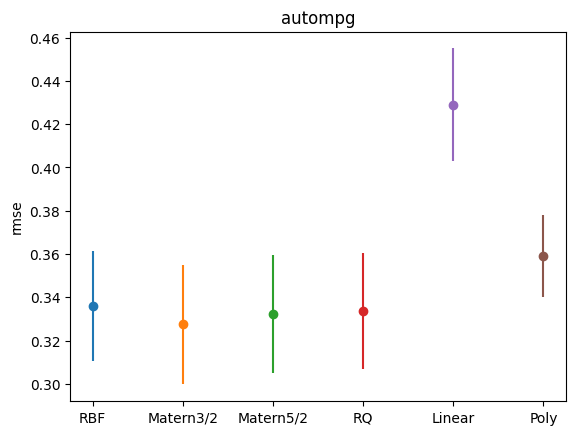

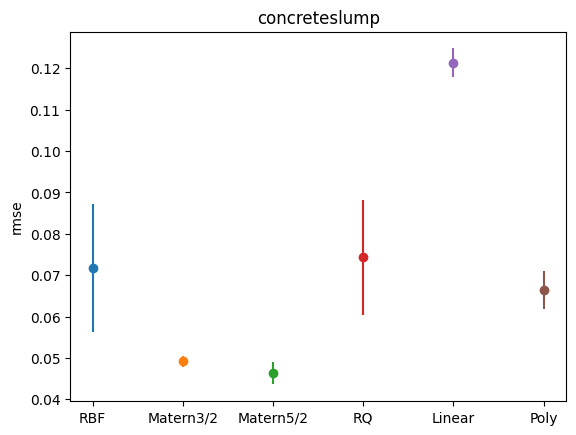

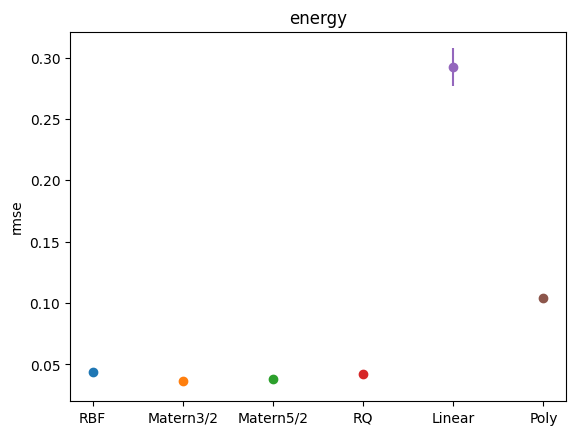

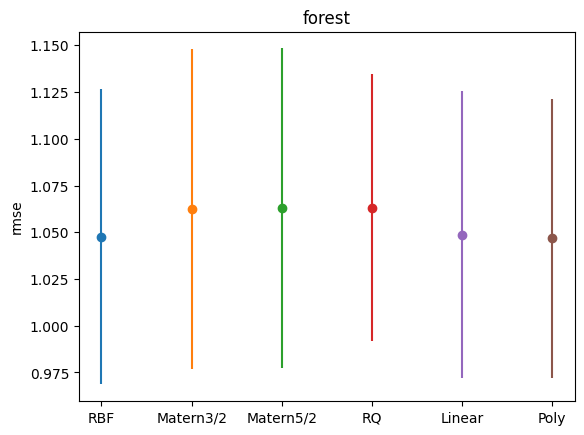

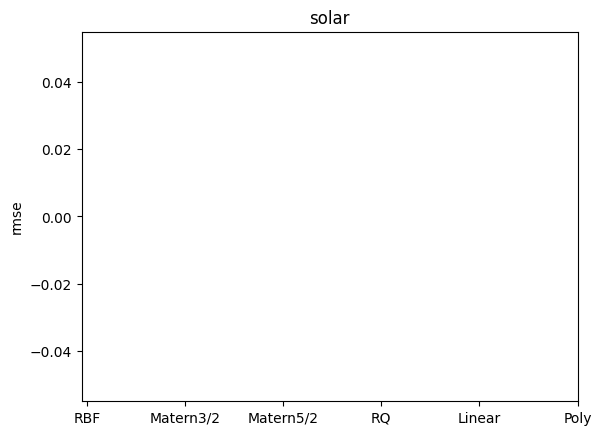

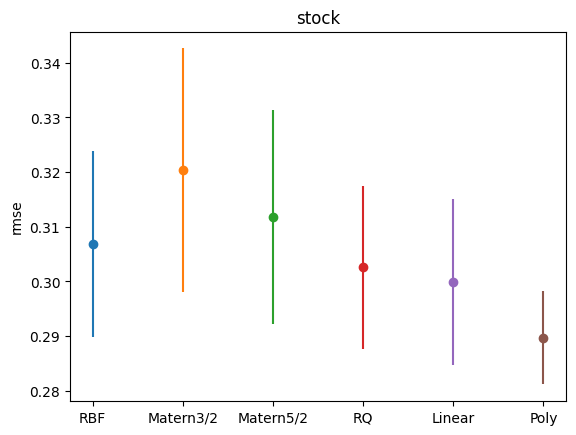

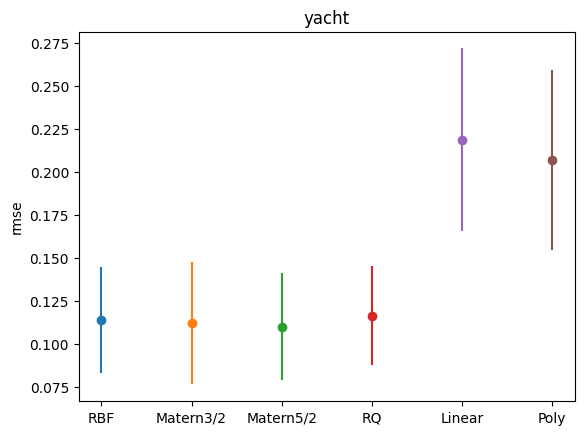

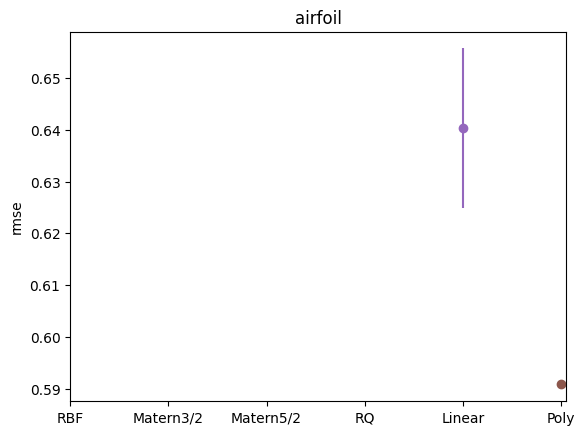

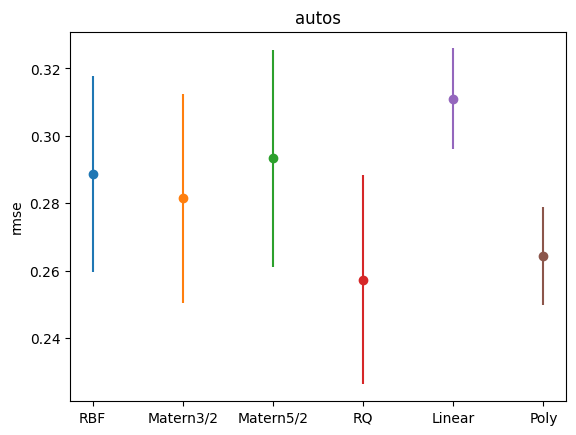

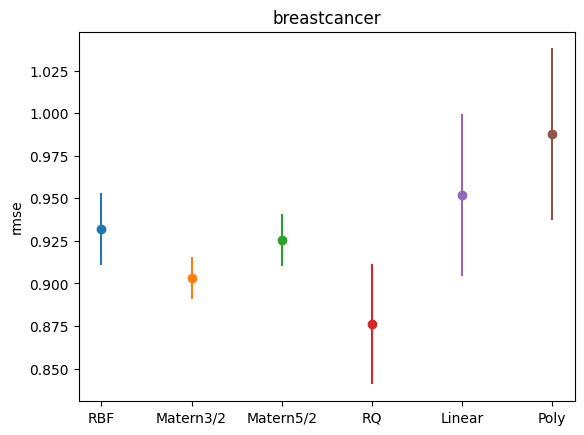

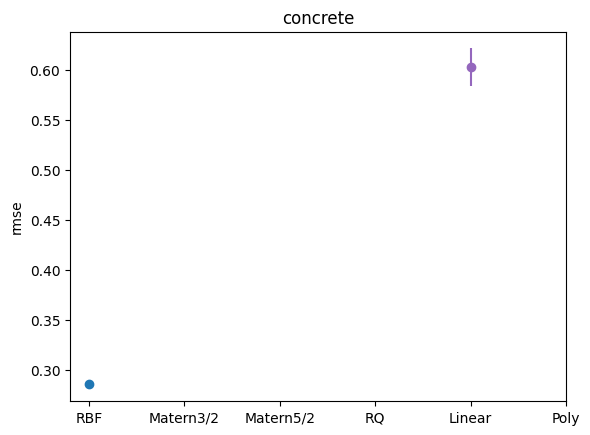

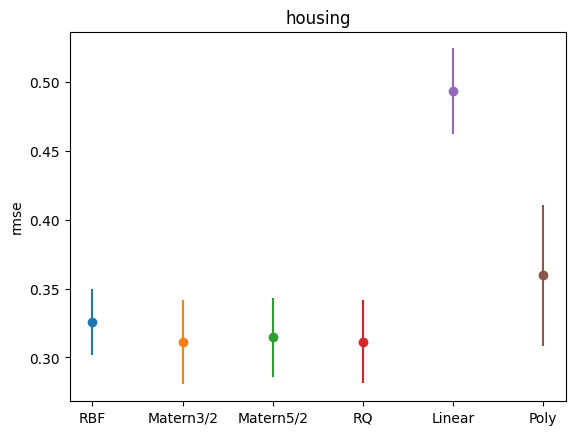

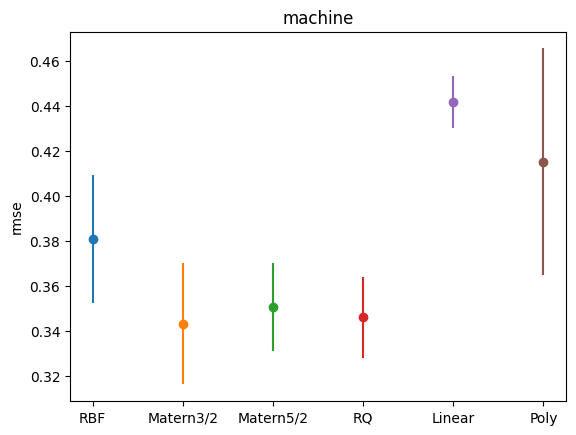

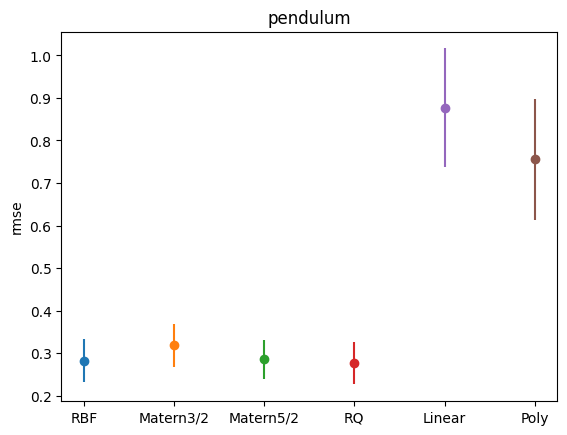

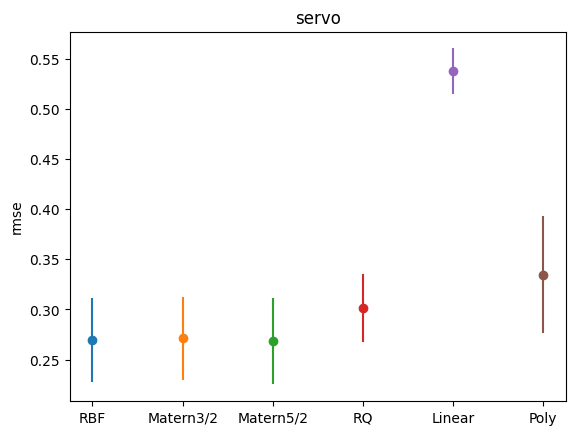

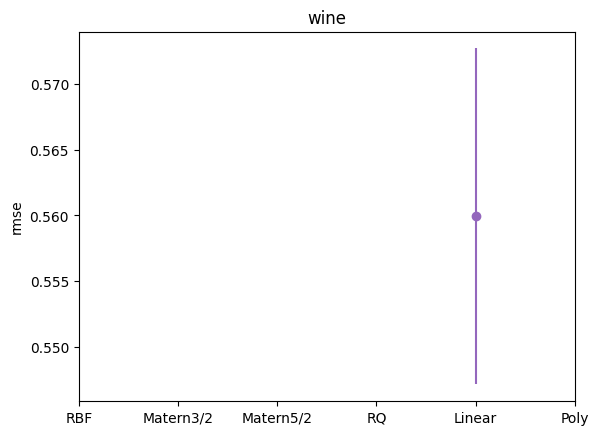

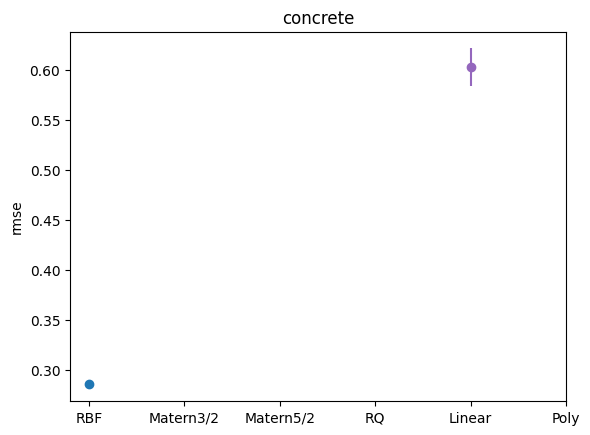

In [296]:
error_measure = "rmse"
for dataset_name in test_datasets:
    plt.figure()
    for i, kernel_name in enumerate(kernel_names[:num_kernels]):
        aqui = np.array(all_results[dataset_name][kernel_name][error_measure])
        plt.scatter(i,np.nanmean(aqui))
        plt.errorbar(i,np.nanmean(aqui),np.nanstd(aqui)/np.sqrt(np.sum(1-np.isnan(aqui))))
    plt.xticks(range(num_kernels),kernel_names[:num_kernels])  
    # plt.ylim((0,1)) 
    plt.ylabel(error_measure) 
    plt.title(dataset_name)

# error_measure = "mae"
# for dataset_name in test_datasets[:1]:
#     plt.figure()
#     for i, kernel_name in enumerate(kernel_names[:num_kernels]):
#         aqui = np.array(all_results[dataset_name][kernel_name][error_measure])
#         plt.scatter(i,aqui.mean())
#         plt.errorbar(i,aqui.mean(),aqui.std()/np.sqrt(3))
#     plt.xticks(range(num_kernels),kernel_names[:num_kernels])   
#     plt.ylabel(error_measure)   
#     plt.title(dataset_name) 


# error_measure = "nlpd"
# for dataset_name in test_datasets[:1]:
#     plt.figure()
#     for i, kernel_name in enumerate(kernel_names[:num_kernels]):
#         aqui = np.array(all_results[dataset_name][kernel_name][error_measure])
#         plt.scatter(i,aqui.mean())
#         plt.errorbar(i,aqui.mean(),aqui.std()/np.sqrt(3))
#     plt.xticks(range(num_kernels),kernel_names[:num_kernels])   
#     plt.ylabel(error_measure)    
#     plt.title(dataset_name)  